In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score


from sklearn import preprocessing
import torch.optim as optim
import torch.nn.functional as F
import plotly as pl

In [2]:
class CustomDataset(Dataset):
    def __init__(self, dataset_path):
        data, self.nrof_emb_categories, self.unique_categories = pd.read_pickle(dataset_path)

        self.embedding_columns = ['workclass_cat', 'education_cat', 'marital-status_cat', 'occupation_cat',
                                  'relationship_cat', 'race_cat',
                                  'sex_cat', 'native-country_cat']
        self.nrof_emb_categories = {key + '_cat': val for key, val in self.nrof_emb_categories.items()}
        self.numeric_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
                                'hours-per-week']

        self.columns = self.embedding_columns + self.numeric_columns

        self.X = data[self.columns].reset_index(drop=True)
        self.y = np.asarray([0 if el == '<50k' else 1 for el in data['salary'].values], dtype=np.int32)
        
        self.X['education-num'] = self.X['education-num'].fillna(0)

        return

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):

        row = self.X.take([idx], axis=0).values
        #упростим для табнета и не будем делать еще эмбединги категориальных переменных
        #row = {col: torch.tensor(row[col], dtype=torch.float32) for i, col in enumerate(self.columns)}

        return torch.Tensor(row), np.float32(self.y[idx])

In [3]:
TRAIN_PATH = 'train_adult.pickle'
TEST_PATH = 'valid_adult.pickle'
train_dataset = CustomDataset(TRAIN_PATH)
test_dataset = CustomDataset(TEST_PATH)
train_loader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=512, shuffle=False)

In [4]:
def seed_everything(seed=7):
    np.random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=7)

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [6]:
class Sparsemax(nn.Module):
    def __init__(self, dim=None):
        super(Sparsemax, self).__init__()
        self.dim = -1 if dim is None else dim

    def forward(self, input):
        input = input.transpose(0, self.dim)
        original_size = input.size()
        input = input.reshape(input.size(0), -1)
        input = input.transpose(0, 1)
        dim = 1

        number_of_logits = input.size(dim)
        
        input = input - torch.max(input, dim=dim, keepdim=True)[0].expand_as(input)
        zs = torch.sort(input=input, dim=dim, descending=True)[0]
        range = torch.arange(start=1, end=number_of_logits + 1, device=device,step=1, dtype=input.dtype).view(1, -1)
        range = range.expand_as(zs)

        bound = 1 + range * zs
        cumulative_sum_zs = torch.cumsum(zs, dim)
        is_gt = torch.gt(bound, cumulative_sum_zs).type(input.type())
        k = torch.max(is_gt * range, dim, keepdim=True)[0]
        zs_sparse = is_gt * zs
        taus = (torch.sum(zs_sparse, dim, keepdim=True) - 1) / k
        taus = taus.expand_as(input)
        self.output = torch.max(torch.zeros_like(input), input - taus)
        output = self.output
        output = output.transpose(0, 1)
        output = output.reshape(original_size)
        output = output.transpose(0, self.dim)
        return output

    def backward(self, grad_output):
        dim = 1
        nonzeros = torch.ne(self.output, 0)
        sum = torch.sum(grad_output * nonzeros, dim=dim) / torch.sum(nonzeros, dim=dim)
        self.grad_input = nonzeros * (grad_output - sum.expand_as(grad_output))
        return self.grad_input

In [7]:
def initialize_non_glu(module,inp_dim,out_dim):
    gain = np.sqrt((inp_dim+out_dim)/np.sqrt(4*inp_dim))
    torch.nn.init.xavier_normal_(module.weight, gain=gain)
    
class GBN(nn.Module):
    def __init__(self,inp,vbs=128,momentum=0.01):
        super().__init__()
        self.bn = nn.BatchNorm1d(inp,momentum=momentum)
        self.vbs = vbs

    def forward(self,x):
        chunk = torch.chunk(x,max(1,x.size(0)//self.vbs),0)
        res = [self.bn(y) for y in chunk ]
        return torch.cat(res,0)

class GLU(nn.Module):
    def __init__(self,inp_dim,out_dim,fc=None,vbs=128):
        super().__init__()
        if fc:
            self.fc = fc
        else:
            self.fc = nn.Linear(inp_dim,out_dim*2)
        self.bn = GBN(out_dim*2,vbs=vbs) 
        self.od = out_dim

    def forward(self,x):
        x = self.bn(self.fc(x))
        return x[:,:self.od]*torch.sigmoid(x[:,self.od:])
    

class FeatureTransformer(nn.Module):
    def __init__(self,inp_dim,out_dim,shared,n_ind,vbs=128):
        super().__init__()
        first = True
        self.shared = nn.ModuleList()
        if shared:
            self.shared.append(GLU(inp_dim,out_dim,shared[0],vbs=vbs))
            first= False    
            for fc in shared[1:]:
                self.shared.append(GLU(out_dim,out_dim,fc,vbs=vbs))
        else:
            self.shared = None
        self.independ = nn.ModuleList()
        if first:
            self.independ.append(GLU(inp,out_dim,vbs=vbs))
        for x in range(first, n_ind):
            self.independ.append(GLU(out_dim,out_dim,vbs=vbs))
        self.scale = torch.sqrt(torch.tensor([.5],device=device))

    def forward(self,x):
        if self.shared:
            x = self.shared[0](x)
            for glu in self.shared[1:]:
                x = torch.add(x, glu(x))
                x = x*self.scale
        for glu in self.independ:
            x = torch.add(x, glu(x))
            x = x*self.scale
        return x

class AttentionTransformer(nn.Module):
    def __init__(self,inp_dim,out_dim,relax,vbs=128):
        super().__init__()
        self.fc = nn.Linear(inp_dim,out_dim)
        self.bn = GBN(out_dim,vbs=vbs)
        self.smax = Sparsemax()
        self.r = torch.tensor([relax],device=device)

    def forward(self,a,priors):
        a = self.bn(self.fc(a))
        mask = self.smax(a*priors)
        priors =priors*(self.r-mask)
        return mask

class DecisionStep(nn.Module):
    def __init__(self,inp_dim,n_d,n_a,shared,n_ind,relax,vbs=128):
        super().__init__()
        self.fea_tran = FeatureTransformer(inp_dim,n_d+n_a,shared,n_ind,vbs)
        self.atten_tran = AttentionTransformer(n_a,inp_dim,relax,vbs)

    def forward(self,x,a,priors):
        mask = self.atten_tran(a,priors)
        loss = ((-1)*mask*torch.log(mask+1e-10)).mean()
        x = self.fea_tran(x*mask)
        return x,loss

class TabNet(nn.Module):
    def __init__(self,inp_dim,final_out_dim,n_d=64,n_a=64,n_shared=2,n_ind=2,n_steps=5,relax=1.2,vbs=128):
        super().__init__()
        if n_shared>0:
            self.shared = nn.ModuleList()
            self.shared.append(nn.Linear(inp_dim,2*(n_d+n_a)))
            for x in range(n_shared-1):
                self.shared.append(nn.Linear(n_d+n_a,2*(n_d+n_a)))
        else:
            self.shared=None
        self.first_step = FeatureTransformer(inp_dim,n_d+n_a,self.shared,n_ind) 
        self.steps = nn.ModuleList()
        for x in range(n_steps-1):
            self.steps.append(DecisionStep(inp_dim,n_d,n_a,self.shared,n_ind,relax,vbs))
        self.fc = nn.Linear(n_d,final_out_dim)
        self.bn = nn.BatchNorm1d(inp_dim)
        self.n_d = n_d
    def forward(self,x):
 
        return output

In [8]:
model = TabNet(14,1,n_d=7,n_a=7,n_shared=1,n_ind=2,n_steps=3,relax=1.5,vbs=128)
optimizer = optim.AdamW(model.parameters())
loss_func = nn.BCEWithLogitsLoss()
model.to(device)
n_epochs = 10

train_losses = []
train_auc = []
test_losses = []
test_auc = []

seed_everything(7)

t = time.time()
for x in range(n_epochs):
    model.train()
    for inp,tar in train_loader:
        optimizer.zero_grad()
        inp = inp.reshape(-1, 14)
        tar = tar.reshape(-1, 1)
        out = model(inp)
        loss = loss_func(out,tar.to(device))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
        train_auc.append(roc_auc_score(tar.detach().numpy(), torch.sigmoid(out).detach().numpy()))
    model.eval()
    with torch.no_grad():
        for inp,tar in test_loader:
            inp = inp.reshape(-1, 14)
            tar = tar.reshape(-1, 1)
            out,_ = model(inp)
            loss = loss_func(out,tar.to(device))
            test_losses.append(loss.detach().numpy())
            test_auc.append(roc_auc_score(tar.detach().numpy(), torch.sigmoid(out).detach().numpy()))
    print(f'epoch: {x}, train_loss: {train_losses[-1]: .2f}, train_auc: {train_auc[-1]: .2f},  test_loss: {test_losses[-1]: .2f}, test_auc: {test_auc[-1]: .2f}, elapsed_time: {(time.time() - t): .2f}')
    t = time.time()

epoch: 0, train_loss:  0.66, train_auc:  0.76,  test_loss:  0.74, test_auc:  0.72, elapsed_time:  10.43
epoch: 1, train_loss:  0.54, train_auc:  0.81,  test_loss:  0.60, test_auc:  0.83, elapsed_time:  10.10
epoch: 2, train_loss:  0.47, train_auc:  0.84,  test_loss:  0.47, test_auc:  0.84, elapsed_time:  10.04
epoch: 3, train_loss:  0.44, train_auc:  0.82,  test_loss:  0.41, test_auc:  0.87, elapsed_time:  10.38
epoch: 4, train_loss:  0.38, train_auc:  0.88,  test_loss:  0.37, test_auc:  0.88, elapsed_time:  12.13
epoch: 5, train_loss:  0.38, train_auc:  0.89,  test_loss:  0.35, test_auc:  0.89, elapsed_time:  10.21
epoch: 6, train_loss:  0.36, train_auc:  0.87,  test_loss:  0.35, test_auc:  0.89, elapsed_time:  10.19
epoch: 7, train_loss:  0.36, train_auc:  0.86,  test_loss:  0.33, test_auc:  0.90, elapsed_time:  10.26
epoch: 8, train_loss:  0.35, train_auc:  0.89,  test_loss:  0.33, test_auc:  0.91, elapsed_time:  10.41
epoch: 9, train_loss:  0.34, train_auc:  0.88,  test_loss:  0.32

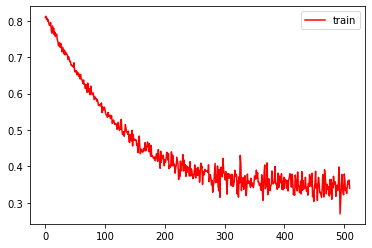

In [9]:
plt.plot(train_losses, 'r', label='train')
plt.legend()
plt.show()

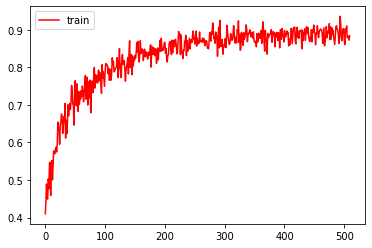

In [10]:
plt.plot(train_auc, 'r', label='train')
plt.legend()
plt.show()

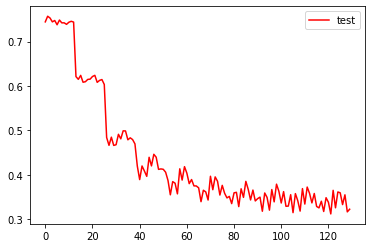

In [11]:
plt.plot(test_losses, 'r', label='test')
plt.legend()
plt.show()

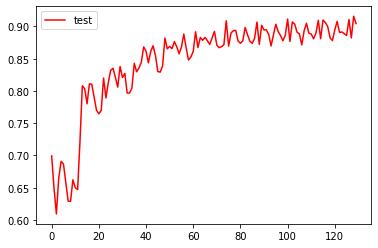

In [12]:
plt.plot(test_auc, 'r', label='test')
plt.legend()
plt.show()

Не часто сейчас используют собственные реализации и разбираются в том, что запускают...Давайте попробуем использовать уже готовую реализацию сетки и увидим, какой будет результат

In [13]:
!pip install pytorch-tabnet

In [16]:
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric

In [38]:
class RocAuc(Metric):
    def __init__(self):
        self._name = "roc_auc"
        self._maximize = True

    def __call__(self, y_true, y_score):
        auc = roc_auc_score(y_true, y_score[:, 1])
        return auc

clf = TabNetClassifier(
    n_d=7,
    n_a=7,
    n_shared=1,
    n_steps=3,
    gamma=1.5, #relax
    optimizer_fn=optim.AdamW,
    mask_type='sparsemax')

Device used : cpu


In [22]:
X_train = train_dataset.X.copy()
y_train = train_dataset.y.copy()

X_test = test_dataset.X.copy()
y_test = test_dataset.y.copy()

In [39]:
clf.fit(
    X_train.values,
    y_train,
    eval_set=[(X_train.values, y_train), (X_test.values, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=[RocAuc],
    max_epochs=10,
    batch_size=512,
    virtual_batch_size=64
)

epoch 0  | loss: 0.44657 | train_roc_auc: 0.70006 | valid_roc_auc: 0.69299 |  0:00:03s
epoch 1  | loss: 0.39431 | train_roc_auc: 0.79281 | valid_roc_auc: 0.79427 |  0:00:06s
epoch 2  | loss: 0.38577 | train_roc_auc: 0.84877 | valid_roc_auc: 0.84864 |  0:00:09s
epoch 3  | loss: 0.37639 | train_roc_auc: 0.86269 | valid_roc_auc: 0.864   |  0:00:12s
epoch 4  | loss: 0.37291 | train_roc_auc: 0.87063 | valid_roc_auc: 0.8691  |  0:00:15s
epoch 5  | loss: 0.36686 | train_roc_auc: 0.88002 | valid_roc_auc: 0.88049 |  0:00:18s
epoch 6  | loss: 0.35843 | train_roc_auc: 0.88929 | valid_roc_auc: 0.88518 |  0:00:21s
epoch 7  | loss: 0.34915 | train_roc_auc: 0.89508 | valid_roc_auc: 0.89222 |  0:00:24s
epoch 8  | loss: 0.34259 | train_roc_auc: 0.89696 | valid_roc_auc: 0.8945  |  0:00:27s
epoch 9  | loss: 0.34244 | train_roc_auc: 0.89696 | valid_roc_auc: 0.89337 |  0:00:30s
Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_valid_roc_auc = 0.8945
Best weights from best epoch

А тепепрь давайте попробуем все же включить какую-то предобработку категориальных переменных!

In [41]:
train_dataset.embedding_columns

['workclass_cat',
 'education_cat',
 'marital-status_cat',
 'occupation_cat',
 'relationship_cat',
 'race_cat',
 'sex_cat',
 'native-country_cat']

In [52]:
cat_features_idx = [i for i, feature in enumerate(train_dataset.X.columns.values) 
                      if feature in train_dataset.embedding_columns]
cat_features_dims = [len(train_dataset.X.iloc[:, col].unique()) for col in cat_features_idx]

In [55]:
clf_with_emb = TabNetClassifier(
    cat_idxs=cat_features_idx,
    cat_dims=cat_features_dims,
    cat_emb_dim=4,
    n_d=7,
    n_a=7,
    n_shared=1,
    n_steps=3,
    gamma=1.5, #relax
    optimizer_fn=optim.AdamW,
    mask_type='sparsemax')

clf_with_emb.fit(
    X_train.values,
    y_train,
    eval_set=[(X_train.values, y_train), (X_test.values, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=[RocAuc],
    max_epochs=10,
    batch_size=512,
    virtual_batch_size=64
)

Device used : cpu
epoch 0  | loss: 0.47805 | train_roc_auc: 0.72842 | valid_roc_auc: 0.72603 |  0:00:03s
epoch 1  | loss: 0.40708 | train_roc_auc: 0.82461 | valid_roc_auc: 0.82522 |  0:00:07s
epoch 2  | loss: 0.39003 | train_roc_auc: 0.8619  | valid_roc_auc: 0.86614 |  0:00:11s
epoch 3  | loss: 0.38225 | train_roc_auc: 0.87129 | valid_roc_auc: 0.87143 |  0:00:15s
epoch 4  | loss: 0.37484 | train_roc_auc: 0.87964 | valid_roc_auc: 0.87982 |  0:00:19s
epoch 5  | loss: 0.36185 | train_roc_auc: 0.8869  | valid_roc_auc: 0.88679 |  0:00:23s
epoch 6  | loss: 0.35576 | train_roc_auc: 0.8911  | valid_roc_auc: 0.89001 |  0:00:27s
epoch 7  | loss: 0.34963 | train_roc_auc: 0.89474 | valid_roc_auc: 0.89468 |  0:00:31s
epoch 8  | loss: 0.34375 | train_roc_auc: 0.89656 | valid_roc_auc: 0.89608 |  0:00:35s
epoch 9  | loss: 0.33809 | train_roc_auc: 0.90042 | valid_roc_auc: 0.89963 |  0:00:39s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_valid_roc_auc = 0.89963
Best weig